In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)


In [2]:
df = pd.read_csv("data/T1.csv")


Inspect the data structure to check the number of records, column names, data types and missing values

In [ ]:
df.shape # Check the number of records and features
df.head() # Display the first few records
df.tail() # Display the last few records
df.info() # Check for missing values and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [ ]:
df.columns # List all column names


Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')

In [8]:
df.isna().sum() # Count missing values in each column

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [15]:
df["Date/Time"].head(10)


0    01 01 2018 00:00
1    01 01 2018 00:10
2    01 01 2018 00:20
3    01 01 2018 00:30
4    01 01 2018 00:40
5    01 01 2018 00:50
6    01 01 2018 01:00
7    01 01 2018 01:10
8    01 01 2018 01:20
9    01 01 2018 01:30
Name: Date/Time, dtype: object

In [19]:
df["Date/Time"].sample(10, random_state=42)


8057     02 03 2018 10:40
8059     02 03 2018 11:00
50250    30 12 2018 01:20
14774    18 04 2018 04:50
49374    23 12 2018 23:20
22716    12 06 2018 17:30
26364    08 07 2018 07:30
49234    23 12 2018 00:00
11993    29 03 2018 18:50
15125    20 04 2018 15:20
Name: Date/Time, dtype: object

In [20]:
# Try parsing mixed formats robustly
dt = pd.to_datetime(df["Date/Time"], errors="coerce", dayfirst=True)

# How many failed to parse?
failed = dt.isna().sum()
print("Unparseable datetime rows:", failed)

# Assign back + sort
df["Date/Time"] = dt
df = df.dropna(subset=["Date/Time"]).sort_values("Date/Time").reset_index(drop=True)


Unparseable datetime rows: 0


In [ ]:
df["Date/Time"].min(), df["Date/Time"].max() # Check time range


(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-12-31 23:50:00'))

In [ ]:
df["Date/Time"].diff().value_counts().head(10) # Check time differences between records


Date/Time
0 days 00:10:00    50497
0 days 00:20:00       11
0 days 00:40:00        2
0 days 03:00:00        1
4 days 08:20:00        1
0 days 00:50:00        1
0 days 01:40:00        1
0 days 01:00:00        1
0 days 02:10:00        1
0 days 06:30:00        1
Name: count, dtype: int64

In [ ]:
df["Date/Time"].duplicated().sum() # Check for duplicate timestamps


np.int64(0)

In [24]:
delta_counts = df["Date/Time"].diff().value_counts()
most_common_delta = delta_counts.index[0]
print("Most common sampling interval:", most_common_delta)

gaps = df["Date/Time"].diff() > most_common_delta
print("Number of gaps larger than expected:", gaps.sum())

df.loc[gaps, ["Date/Time"]].head()


Most common sampling interval: 0 days 00:10:00
Number of gaps larger than expected: 32


,Date/Time
491,2018-01-04 12:40:00
768,2018-01-06 11:30:00
1577,2018-01-12 02:30:00
3617,2018-01-30 14:40:00
9188,2018-03-10 07:20:00


# 3 — Final Time-Series Conclusions
Temporal Characteristics

The SCADA data is predominantly sampled at 10-minute intervals, consistent with standard industrial wind turbine monitoring.
A small number of larger time gaps were observed, likely corresponding to turbine downtime, maintenance activities, or communication outages.
These gaps are retained at this stage to preserve the authenticity of the operational timeline and will be handled explicitly during preprocessing.

In [25]:
df["Date/Time"] = pd.to_datetime(df["Date/Time"])
df = df.sort_values("Date/Time")
df = df.reset_index(drop=True)


Visual inspection of key signals

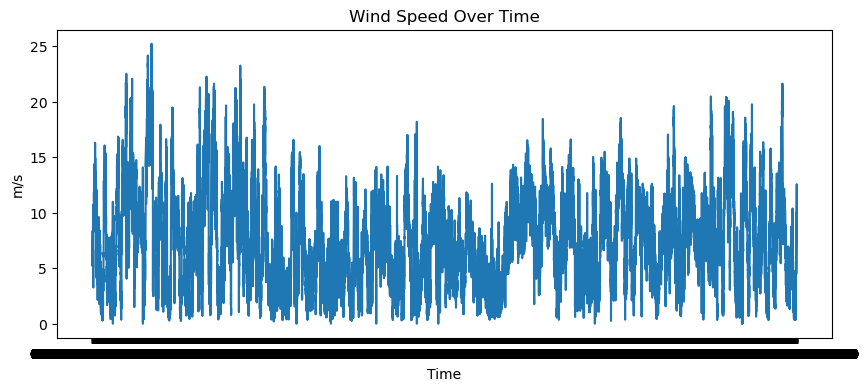

In [7]:
# Wind speed over time plot
plt.figure(figsize=(10,4))
plt.plot(df["Date/Time"], df["Wind Speed (m/s)"])
plt.title("Wind Speed Over Time")
plt.xlabel("Time")
plt.ylabel("m/s")
plt.show()


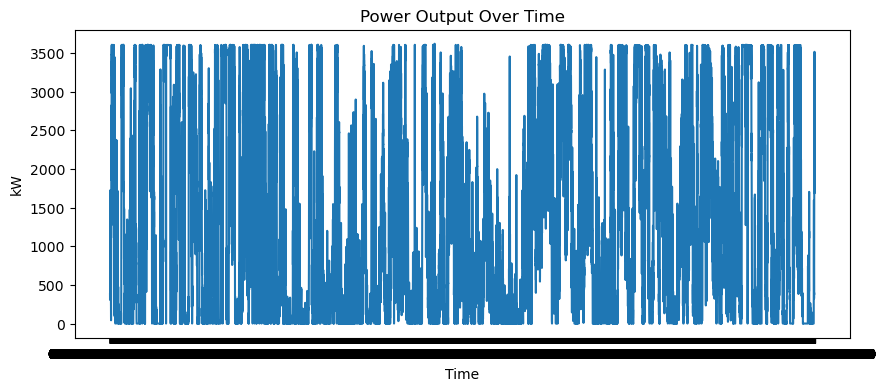

In [10]:
# Power output over time plot
plt.figure(figsize=(10,4))
plt.plot(df["Date/Time"], df["LV ActivePower (kW)"])
plt.title("Power Output Over Time")
plt.xlabel("Time")
plt.ylabel("kW")
plt.show()


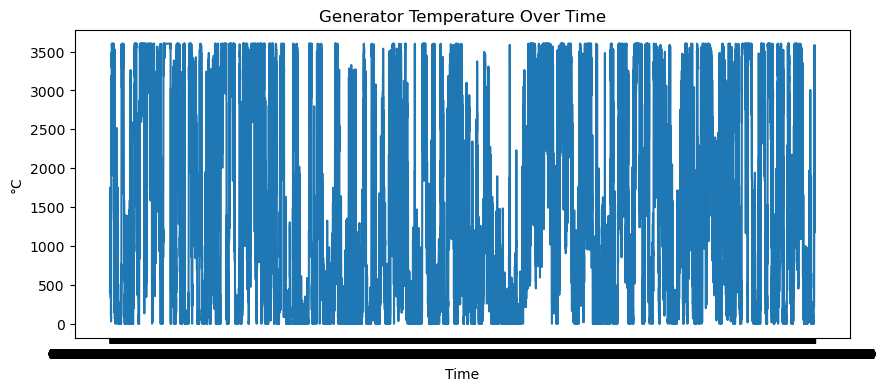

In [13]:
# Generator temperature over time plot
plt.figure(figsize=(10,4))
plt.plot(df["Date/Time"], df["Theoretical_Power_Curve (KWh)"])
plt.title("Generator Temperature Over Time")
plt.xlabel("Time")
plt.ylabel("°C")
plt.show()


# Step 4 — Finalised Assumptions & Constraints

Most data points represent normal turbine operation.

The 10-minute sampling frequency is sufficient to capture gradual fault development.

Short-term fluctuations are expected due to environmental variability.

Extended time gaps correspond to non-operational periods rather than sensor corruption.

Constraints (Final)

No labelled failure events or maintenance annotations are available.

Time gaps introduce irregular sampling that must be addressed before modelling.

Environmental variables may obscure fault-related patterns.

Results represent risk indicators, not definitive failure diagnoses.

# 5 - Data cleaning & signal condition
This is to convert the SCADA logs into a meaningful and consistent dataset suitable for anomaly detection

## 5.1 - Create a clean working xopy
This allows for safe experimentation and ensures reproducibility

In [3]:
df_clean = df.copy()

## 5.2 - Remove non operational times (idle states)
This would be identifying non-operational conditions such as when the wind speed and active power are 0


### 5.2.1 - Identify non-operational conditions 

In [4]:
non_operational = (
    (df_clean["Wind Speed (m/s)"] <= 0) |
    (df_clean["LV ActivePower (kW)"] <= 0)
)

non_operational.sum()


np.int64(10838)

### 5.2.2 - Remove them
Zero power does not mean there is fault. 
Including idle states would cause false anomalies

In [5]:
df_clean = df_clean.loc[~non_operational].reset_index(drop=True)
